In [0]:
!pip install "tensorflow_hub>=0.5.0"
!pip install "tensorflow==1.14"

     |████████████████████████████████| 109.2MB 72kB/s 
     |████████████████████████████████| 3.2MB 31.0MB/s 
     |████████████████████████████████| 491kB 53.8MB/s 
  Found existing installation: tensorboard 2.0.0
    Uninstalling tensorboard-2.0.0:
      Successfully uninstalled tensorboard-2.0.0
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,After what was considered to be the official D...,10,1
1,"This movie was like ""The Disney Channel after ...",1,0
2,Although time has revealed how some of the eff...,8,1
3,A lot has been said about Shinjuku Triad Socie...,10,1
4,In September 2003 36-year-old Jonny Kennedy di...,8,1


In [0]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

In [0]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

In [0]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjn4x_yge', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb1eb5a0fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjn4x_yge', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb1eb5a0fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000);

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjn4x_yge/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjn4x_yge/model.ckpt.


INFO:tensorflow:loss = 88.8515, step = 1


INFO:tensorflow:loss = 88.8515, step = 1


INFO:tensorflow:global_step/sec: 41.1634


INFO:tensorflow:global_step/sec: 41.1634


INFO:tensorflow:loss = 67.38553, step = 101 (2.437 sec)


INFO:tensorflow:loss = 67.38553, step = 101 (2.437 sec)


INFO:tensorflow:global_step/sec: 42.2513


INFO:tensorflow:global_step/sec: 42.2513


INFO:tensorflow:loss = 55.744133, step = 201 (2.366 sec)


INFO:tensorflow:loss = 55.744133, step = 201 (2.366 sec)


INFO:tensorflow:global_step/sec: 41.2855


INFO:tensorflow:global_step/sec: 41.2855


INFO:tensorflow:loss = 58.47676, step = 301 (2.419 sec)


INFO:tensorflow:loss = 58.47676, step = 301 (2.419 sec)


INFO:tensorflow:global_step/sec: 41.1351


INFO:tensorflow:global_step/sec: 41.1351


INFO:tensorflow:loss = 50.97657, step = 401 (2.433 sec)


INFO:tensorflow:loss = 50.97657, step = 401 (2.433 sec)


INFO:tensorflow:global_step/sec: 40.7785


INFO:tensorflow:global_step/sec: 40.7785


INFO:tensorflow:loss = 66.43477, step = 501 (2.449 sec)


INFO:tensorflow:loss = 66.43477, step = 501 (2.449 sec)


INFO:tensorflow:global_step/sec: 40.75


INFO:tensorflow:global_step/sec: 40.75


INFO:tensorflow:loss = 54.530617, step = 601 (2.454 sec)


INFO:tensorflow:loss = 54.530617, step = 601 (2.454 sec)


INFO:tensorflow:global_step/sec: 40.4664


INFO:tensorflow:global_step/sec: 40.4664


INFO:tensorflow:loss = 46.009552, step = 701 (2.477 sec)


INFO:tensorflow:loss = 46.009552, step = 701 (2.477 sec)


INFO:tensorflow:global_step/sec: 40.7467


INFO:tensorflow:global_step/sec: 40.7467


INFO:tensorflow:loss = 56.255432, step = 801 (2.448 sec)


INFO:tensorflow:loss = 56.255432, step = 801 (2.448 sec)


INFO:tensorflow:global_step/sec: 40.4749


INFO:tensorflow:global_step/sec: 40.4749


INFO:tensorflow:loss = 55.404633, step = 901 (2.471 sec)


INFO:tensorflow:loss = 55.404633, step = 901 (2.471 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpjn4x_yge/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpjn4x_yge/model.ckpt.


INFO:tensorflow:Loss for final step: 54.18482.


INFO:tensorflow:Loss for final step: 54.18482.


In [0]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-10-29T15:01:48Z


INFO:tensorflow:Starting evaluation at 2019-10-29T15:01:48Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /tmp/tmpjn4x_yge/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmpjn4x_yge/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-10-29-15:01:55


INFO:tensorflow:Finished evaluation at 2019-10-29-15:01:55


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.803, accuracy_baseline = 0.5, auc = 0.884253, auc_precision_recall = 0.88390315, average_loss = 0.42873737, global_step = 1000, label/mean = 0.5, loss = 54.68589, precision = 0.7995729, prediction/mean = 0.50677526, recall = 0.80872


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.803, accuracy_baseline = 0.5, auc = 0.884253, auc_precision_recall = 0.88390315, average_loss = 0.42873737, global_step = 1000, label/mean = 0.5, loss = 54.68589, precision = 0.7995729, prediction/mean = 0.50677526, recall = 0.80872


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpjn4x_yge/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpjn4x_yge/model.ckpt-1000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-10-29T15:01:56Z


INFO:tensorflow:Starting evaluation at 2019-10-29T15:01:56Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpjn4x_yge/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmpjn4x_yge/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-10-29-15:02:04


INFO:tensorflow:Finished evaluation at 2019-10-29-15:02:04


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.79512, accuracy_baseline = 0.5, auc = 0.8777161, auc_precision_recall = 0.87924314, average_loss = 0.43870005, global_step = 1000, label/mean = 0.5, loss = 55.95664, precision = 0.79431945, prediction/mean = 0.5041799, recall = 0.79648


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.79512, accuracy_baseline = 0.5, auc = 0.8777161, auc_precision_recall = 0.87924314, average_loss = 0.43870005, global_step = 1000, label/mean = 0.5, loss = 55.95664, precision = 0.79431945, prediction/mean = 0.5041799, recall = 0.79648


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpjn4x_yge/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpjn4x_yge/model.ckpt-1000


Training set accuracy: 0.8029999732971191
Test set accuracy: 0.7951200008392334


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpjn4x_yge/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmpjn4x_yge/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


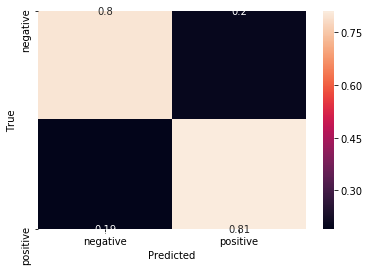

In [0]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["polarity"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");